### **Classifying Song Genre**

In [105]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspect the resultant dataframe
print(echo_tracks.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


In [106]:
import matplotlib.pyplot as plt

# Correlation matrix
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient(cmap='coolwarm')

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


No strong correlations between the features. We can split the data, normalize, and reduce the number of features using PCA.

In [107]:
# Split data
from sklearn.model_selection import train_test_split

# Create features
features = echo_tracks.drop(["genre_top", "track_id"], axis=1).values

# Create labels
labels = echo_tracks["genre_top"].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

In [108]:
# Standardize data
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

Text(0.5, 0, 'Principal Component #')

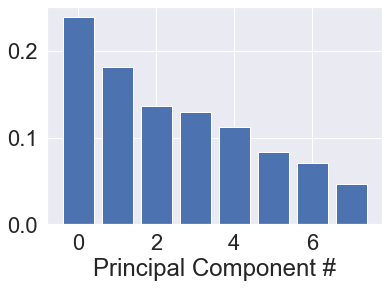

In [109]:
# Apply PCA 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

No clear elbow in this scree plot. Let's try cumulative explained variance plot that determine how many features are required to explain. Let's do 85%.

Text(0.5, 0, 'features #')

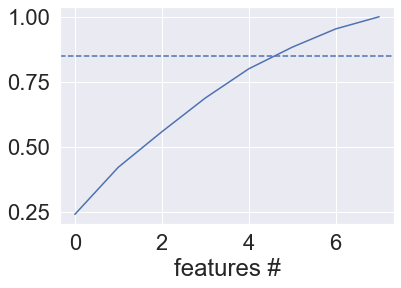

In [110]:
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
ax.set_xlabel('features #')

We can see that feature 6 (index start at 0) can explain 85% of variences. Let's try PCA with 6 components and reduce dimensionality.

In [111]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

Let's apply decision tree

In [112]:
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create our decision tree
tree = DecisionTreeClassifier(random_state=10)

# Train our decision tree
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

class_rep_tree = classification_report(test_labels, pred_labels_tree)
print("Decision Tree: \n", class_rep_tree)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201



85% is decent, but let's not call it a day. Let's try Logistic Regression.

In [113]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logisitic regression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

class_rep_log = classification_report(test_labels, pred_labels_logit)
print("Logistic Regression: \n", class_rep_log)

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Logistic Regression tree has a slightly better performance than Decision Tree so let's stick with that. However, Our Hip-Hop classification is not that good. 

It seems that we have more data points for hip-hop than rock, so it look like our model can only classify just rock song. Let's account for differences in sample size.

In [114]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

Let's see if the bias towards 'rock' is removed while maintaining the model performance.

In [115]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



Nice. It seems like we dont have any bias anymore while our model performance is 80%. Let's try cross-validation to check the model actual performance.

In [116]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array o scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7582417582417582 Logistic Regression: 0.782967032967033


75% and 78%, not that bad. I would call it a success.